In [1]:
!nvidia-smi

Fri Apr 12 13:33:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060       WDDM | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8               18W / 180W|   1196MiB / 12288MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [17]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["mask"])

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [3]:
pip install transformers

  Using cached transformers-4.39.3-py3-none-any.whl.metadata (134 kB)
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     -------------------------------------- 42.0/42.0 kB 675.2 kB/s eta 0:00:00
Using cached transformers-4.39.3-py3-none-any.whl (8.8 MB)
   ---------------------------------------- 0.0/388.9 kB ? eta -:--:--
   --------------------------------------- 388.9/388.9 kB 25.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/269.5 kB ? eta -:--:--
   --------------------------------------- 269.5/269.5 kB 16.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/269.5 kB ? eta -:--:--
   ------------------------------------- -- 256.0/269.5 kB 7.9 MB/s eta 0:00:01
   ---------------------------------------- 269.5/269.5 kB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 70.4 MB/s eta 0:00:00
Note: you may need to restart the kernel

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
pip install datasets

  Using cached datasets-2.18.0-py3-none-any.whl.metadata (20 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached fsspec-2024.2.0-py3-none-any.whl (170 kB)
   ---------------------------------------- 0.0/370.5 kB ? eta -:--:--
   --------------------------------------- 370.5/370.5 kB 24.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/24.8 MB ? eta -:--:--
   --- ------------------------------------ 2.2/24.8 MB 71.3 MB/s eta 0:00:01
   ------ --------------------------------- 4.3/24.8 MB 55.1 MB/s eta 0:00:01
   ---------- ----------------------------- 6.4/24.8 MB 50.9 MB/s e

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [53]:
from PIL import Image
from datasets import Dataset
import os

def create_image_dataset(folder_path, target_size=(256, 256)):
    image_paths = []
    mask_paths = []
    
    # 폴더 내의 모든 파일을 순회
    for image_file in os.listdir(image_folder_path):
        if image_file.endswith(".jpg") or image_file.endswith(".jpeg") or image_file.endswith(".png"):
            image_path = os.path.join(image_folder_path, image_file)
            mask_file = f"masked_image_{image_file}"
            mask_path = os.path.join(mask_folder_path, mask_file)
            
            # 마스킹 파일이 실제로 존재하는지 확인
            if os.path.isfile(mask_path):
                # 이미지와 마스크를 열고 리사이징
                image = Image.open(image_path).resize(target_size)
                mask = Image.open(mask_path).resize(target_size)
                
                # 그레이스케일 이미지를 RGB로 변환
                if image.mode == 'L':
                    image = image.convert('RGB')
                
                image_paths.append(image)
                mask_paths.append(mask)
    
    # 데이터셋 생성
    dataset = Dataset.from_dict({
        'image': image_paths,
        'mask': mask_paths
    })
    
    return dataset

# 폴더 경로
folder_path = './dataset/eye_image_seg/train'
# 데이터셋 생성 (이미지와 마스크를 256x256 크기로 리사이징)
dataset = create_image_dataset(folder_path, target_size=(256, 256))

# 데이터셋 예시 출력 (PIL 이미지 객체이므로, shape 대신 size 속성을 사용)
print(dataset[0]['image'].size, dataset[0]['mask'].size)

(256, 256) (256, 256)


이미지 채널 수: RGB
이미지 채널 수: RGB


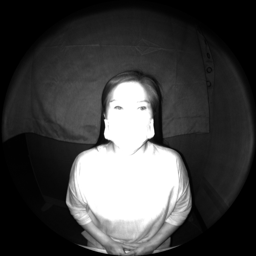

In [55]:
example = dataset[512]
image = example["image"]
image.size
channels = image.mode
print("이미지 채널 수:", channels)
image = image.convert('RGB')
channels = image.mode
print("이미지 채널 수:", channels)
image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

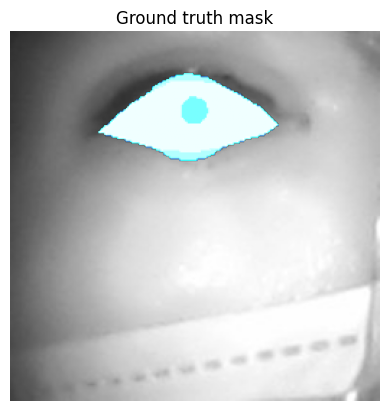

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["mask"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [58]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [59]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [60]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [61]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [62]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [63]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [64]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [65]:
pip install -q monai

Note: you may need to restart the kernel to use updated packages.


In [66]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [69]:
from tqdm import tqdm
import torch

num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for batch in epoch_iterator:
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()

        epoch_losses.append(loss.item())
        epoch_iterator.set_postfix({"loss": loss.item()})

    # Print epoch loss
    mean_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"EPOCH: {epoch+1} | Mean loss: {mean_loss}")


Epoch 1/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:59<00:00,  1.68batch/s, loss=-1.28e+4]


EPOCH: 1 | Mean loss: -4667.481588356737


Epoch 2/50: 100%|████████████████████████████████████████████████████| 1104/1104 [10:57<00:00,  1.68batch/s, loss=-821]


EPOCH: 2 | Mean loss: -12609.333115173422


Epoch 3/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:55<00:00,  1.68batch/s, loss=-2.02e+3]


EPOCH: 3 | Mean loss: -27469.095224021137


Epoch 4/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:57<00:00,  1.68batch/s, loss=-1.66e+3]


EPOCH: 4 | Mean loss: -51702.28546662261


Epoch 5/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:54<00:00,  1.69batch/s, loss=-5.31e+3]


EPOCH: 5 | Mean loss: -88352.70027226987


Epoch 6/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:50<00:00,  1.70batch/s, loss=-6.49e+5]


EPOCH: 6 | Mean loss: -139468.69999042456


Epoch 7/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:54<00:00,  1.69batch/s, loss=-5.24e+5]


EPOCH: 7 | Mean loss: -207636.9260738207


Epoch 8/50: 100%|█████████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-1.9e+4]


EPOCH: 8 | Mean loss: -297015.00273419806


Epoch 9/50: 100%|█████████████████████████████████████████████████| 1104/1104 [10:59<00:00,  1.67batch/s, loss=-2.5e+4]


EPOCH: 9 | Mean loss: -410658.79826200183


Epoch 10/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:59<00:00,  1.68batch/s, loss=-1.28e+6]


EPOCH: 10 | Mean loss: -552609.2583295297


Epoch 11/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-3.46e+4]


EPOCH: 11 | Mean loss: -725593.3389158387


Epoch 12/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:59<00:00,  1.67batch/s, loss=-2.83e+6]


EPOCH: 12 | Mean loss: -938205.024762582


Epoch 13/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:59<00:00,  1.67batch/s, loss=-3.81e+4]


EPOCH: 13 | Mean loss: -1196339.7162148296


Epoch 14/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:52<00:00,  1.69batch/s, loss=-7.01e+4]


EPOCH: 14 | Mean loss: -1503669.678912619


Epoch 15/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:49<00:00,  1.70batch/s, loss=-6.7e+6]


EPOCH: 15 | Mean loss: -1866786.8184708306


Epoch 16/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-9.37e+4]


EPOCH: 16 | Mean loss: -2287191.0453747734


Epoch 17/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-1.85e+5]


EPOCH: 17 | Mean loss: -2776475.136977044


Epoch 18/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-2.43e+5]


EPOCH: 18 | Mean loss: -3344137.395957173


Epoch 19/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-3.97e+5]


EPOCH: 19 | Mean loss: -3989644.6230256455


Epoch 20/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-1.52e+5]


EPOCH: 20 | Mean loss: -4734506.3156490605


Epoch 21/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-2.76e+5]


EPOCH: 21 | Mean loss: -5584795.461447011


Epoch 22/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-2.27e+5]


EPOCH: 22 | Mean loss: -6528076.043301348


Epoch 23/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-2.7e+7]


EPOCH: 23 | Mean loss: -7577365.570765398


Epoch 24/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:55<00:00,  1.68batch/s, loss=-1.84e+7]


EPOCH: 24 | Mean loss: -8779011.507295912


Epoch 25/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-7.76e+5]


EPOCH: 25 | Mean loss: -10135178.656731205


Epoch 26/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-3.15e+7]


EPOCH: 26 | Mean loss: -11637196.44310462


Epoch 27/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-7.41e+5]


EPOCH: 27 | Mean loss: -13297271.924167799


Epoch 28/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-6.68e+7]


EPOCH: 28 | Mean loss: -15136533.902258832


Epoch 29/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:52<00:00,  1.69batch/s, loss=-3.79e+7]


EPOCH: 29 | Mean loss: -17158488.44723732


Epoch 30/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.70batch/s, loss=-5.72e+7]


EPOCH: 30 | Mean loss: -19380705.098052535


Epoch 31/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-4.97e+7]


EPOCH: 31 | Mean loss: -21804042.335597824


Epoch 32/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-4.42e+7]


EPOCH: 32 | Mean loss: -24463156.72514719


Epoch 33/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-9.61e+5]


EPOCH: 33 | Mean loss: -27406393.01135077


Epoch 34/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-1.6e+6]


EPOCH: 34 | Mean loss: -30638357.426658742


Epoch 35/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-2.1e+6]


EPOCH: 35 | Mean loss: -34141595.33372962


Epoch 36/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-1.02e+6]


EPOCH: 36 | Mean loss: -37941193.41103374


Epoch 37/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-1.2e+8]


EPOCH: 37 | Mean loss: -41983163.16162817


Epoch 38/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-3.34e+6]


EPOCH: 38 | Mean loss: -46331974.37143342


Epoch 39/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-2.35e+6]


EPOCH: 39 | Mean loss: -51089536.92532835


Epoch 40/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-2.53e+6]


EPOCH: 40 | Mean loss: -56212485.25226449


Epoch 41/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-1.12e+8]


EPOCH: 41 | Mean loss: -61734838.70108695


Epoch 42/50: 100%|████████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-3.2e+6]


EPOCH: 42 | Mean loss: -67603898.96037138


Epoch 43/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:47<00:00,  1.71batch/s, loss=-1.43e+6]


EPOCH: 43 | Mean loss: -74006281.54325181


Epoch 44/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:51<00:00,  1.70batch/s, loss=-3.18e+8]


EPOCH: 44 | Mean loss: -80885402.89855072


Epoch 45/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-1.48e+8]


EPOCH: 45 | Mean loss: -88210463.7591712


Epoch 46/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-5.87e+6]


EPOCH: 46 | Mean loss: -95968397.59731658


Epoch 47/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-3.88e+6]


EPOCH: 47 | Mean loss: -104394484.50158514


Epoch 48/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-9.87e+6]


EPOCH: 48 | Mean loss: -113331339.6359828


Epoch 49/50: 100%|███████████████████████████████████████████████| 1104/1104 [10:58<00:00,  1.68batch/s, loss=-4.91e+6]


EPOCH: 49 | Mean loss: -122873089.9310462


Epoch 50/50: 100%|██████████████████████████████████████████████████| 1104/1104 [10:53<00:00,  1.69batch/s, loss=-1e+7]

EPOCH: 50 | Mean loss: -133137538.4981884


In [70]:
torch.save(model.state_dict(), "eyeball_model.pth")